### ライブラリのimport

In [5]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas_profiling import ProfileReport
%matplotlib inline
from preprocessing.initial_preprocessing import initial_preprocessing
from preprocessing.drop_emergency_suspicious_height_weight import drop_emergency_suspicious_height_weight
from preprocessing.calculate_bmi_bmr_category import calculate_bmi_bmr_category
from preprocessing.remove_duplicate_ctdi import remove_duplicate_ctdi

/tmp/ipykernel_1086/3916448936.py:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


## 解析用の元データを読み込み

In [6]:
df = pd.read_excel('train_data.xlsx')

## データを前処理
* カラム名の変更
* 複数回スキャンについては,Mean CTDIvolが最大のみ残す
* 救急科などの怪しい身長と体重のデータを削除する

In [7]:
initial_preprocessing(df)
df = remove_duplicate_ctdi(df)
df.reset_index(drop=True, inplace=True)
# df_allで後で、身長体重を代入する分を分けられるようにしておく
df_all = df
df = drop_emergency_suspicious_height_weight(df)

正常に処理が行われました。


### 身長・体重の最終確認: この部分は自分で確認しないと危険

In [8]:
df['height_cm'].sort_values()

1200    101.0
97      101.0
2241    101.0
2362    101.0
1011    101.0
        ...  
8610    190.9
7978    190.9
790     193.0
8       193.0
5567    193.0
Name: height_cm, Length: 8958, dtype: float64

In [9]:
index = df['height_cm'].sort_values(ascending=True)[:30].index.to_list()

In [10]:
df[['scanning length', 'height_cm', 'weight_kg', 'id', 'study_date', 'target region', 'Mean CTDIvol']].loc[index]

,scanning length,height_cm,weight_kg,id,study_date,target region,Mean CTDIvol
1200,796.77,101.0,39.80,75206,2021-06-18,Chest,6.70
97,626.53,101.0,39.80,75206,2021-01-14,Abdomen,12.78
2241,852.06,101.0,39.80,75206,2021-04-21,Chest,6.45
2362,621.51,101.0,39.80,75206,2021-06-02,Abdomen,17.10
1011,796.77,101.0,39.80,75206,2021-05-18,Chest,7.38
265,567.16,101.0,39.80,75206,2021-02-04,Chest,6.03
620,827.20,101.0,39.80,75206,2021-03-29,Chest,6.13
6436,506.63,117.7,76.40,9326611,2023-02-10,Bronchus,10.38
3529,531.81,117.7,76.40,9326611,2022-01-21,Bronchus,9.90
106,456.72,117.7,76.40,9326611,2021-01-15,Chest,9.14


In [11]:
# 最終的な怪しいデータに関しては直接データを確認して削除する
drop_ids = [75206, 9326611, 17049]
for ids in drop_ids:
    df = df[~(df['id'] == ids)]
df.reset_index(drop=True, inplace=True)

### 身長体重予測、線量予測、異常検知でも使用しない項目を削除する

In [12]:
unuse_cols = ['hospital_ward', 'modality', 'adult_child', 'department', 'preset_name']
df.drop(labels=unuse_cols, axis=1, inplace=True)

In [ ]:
df.to_excel('preprocess_all_scan_data.xlsx')

### Pandas_Profilling

In [462]:
profile= ProfileReport(df, title='preprocessing_data')
profile.to_file('preprocessing_data.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/pandas_profiling/visualisation/utils.py:73: UserWarning: Glyph 21336 (\N{CJK UNIFIED IDEOGRAPH-5358}) missing from current font.
  plt.savefig(
/opt/anaconda3/lib/python3.9/site-packages/pandas_profiling/visualisation/utils.py:73: UserWarning: Glyph 32020 (\N{CJK UNIFIED IDEOGRAPH-7D14}) missing from current font.
  plt.savefig(
/opt/anaconda3/lib/python3.9/site-packages/pandas_profiling/visualisation/utils.py:73: UserWarning: Glyph 36896 (\N{CJK UNIFIED IDEOGRAPH-9020}) missing from current font.
  plt.savefig(
/opt/anaconda3/lib/python3.9/site-packages/pandas_profiling/visualisation/utils.py:73: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from current font.
  plt.savefig(
/opt/anaconda3/lib/python3.9/site-packages/pandas_profiling/visualisation/utils.py:73: UserWarning: Glyph 12511 (\N{KATAKANA LETTER MI}) missing from current font.
  plt.savefig(
/opt/anaconda3/lib/python3.9/site-packages/pandas_profiling/visualisation

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 新たな特徴量を作成する

* BMI(Body Mass Index)  
  $BMI = weight(kg) / height(m)^2$  
  
* BMR(Basal Metabolic Rate: 基礎代謝率): 年齢、性別、身長、体重に基づいて計算される。ハリス・ベネディクト方程式と呼ばれる  
  男性$BMR=66.47 + (13.75*weight[kg]) + (5.003*height[cm]) - (6.755*age[歳])$  
  女性$BMR=655.1 + (9.563*weight[kg]) + (1.85*height[cm]) - (4.676*age[歳])$  
  
* 体格指数(Rohrer's index) ：学童期に適するとあるので、今回は使わない  
  $Rohrer's index = weight[kg] / height[m]^3$

体格指数（BMI）: 体重（kg）を身長（m）の二乗で割ったもので、以下のように分類されます（成人向けのWHOのガイドライン）。

18.5未満: 低体重（痩せ型）: underweight    
18.5～24.9: 標準体重: normal weight   
25.0～29.9: 肥満（1度）:obesity class1  
30.0～34.9: 肥満（2度）:obesity class2  
35.0～39.9: 肥満（3度）:obesity class3    
40以上: 肥満（4度、重症）:obesity class4

In [18]:
from preprocessing.calculate_bmi_bmr_category import calculate_bmi_bmr_category

In [19]:
calculate_bmi_bmr_category(df)

### 前処理が終了したデータを保存する。

In [493]:
df.to_excel('preprocessed_train_data.xlsx', index=False)

In [39]:
df.columns

Index(['accession', 'scan protocol', 'scan series', 'target region',
       'scanning length', 'kV', 'mean mA', 'max mA', 'pitch factor',
       'nomial total collimation width', 'exposure time per rotation',
       'exposure time', 'CTDIw phantom type', 'Mean CTDIvol', 'DLP',
       'study_date', 'id', 'age', 'gender', 'height_cm', 'weight_kg',
       'scan_area', 'scan_method', 'bmi', 'bmr', 'category_bmi'],
      dtype='object')

In [20]:
# 年代(generation)の新しいカラムを作成する
df['generation'] = (df['age'] // 10) * 10

In [21]:
df.columns

Index(['CTDIw phantom type', 'Mean CTDIvol', 'age', 'gender', 'height_cm',
       'weight_kg', 'scan_area', 'scan_method', 'generation', 'bmi', 'bmr',
       'category_bmi'],
      dtype='object')

In [1]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_excel('preprocessed_train_data.xlsx')

In [4]:
# 線量予測で使えない特徴量を削除する
drop_columns = ['accession', 'scan protocol', 'scan series', 'scanning length',
                'kV', 'mean mA', 'max mA', 'pitch factor', 'nomial total collimation width',
                'exposure time per rotation', 'exposure time', 'study_date', 'id', 'DLP', 'target region']

df = df.drop(drop_columns, axis=1)
df.head(2)

,CTDIw phantom type,Mean CTDIvol,age,gender,height_cm,weight_kg,scan_area,scan_method,bmi,bmr,category_bmi
0,IEC Body Dosimetry Phantom,5.86,86,F,150.0,49.1,胸部CT,単純,21.82,1000.01,normal weight
1,IEC Body Dosimetry Phantom,7.41,61,M,163.0,74.0,胸部CT,単純,27.85,1487.40,obesity class1


In [6]:
df.to_excel('drop_train_data.xlsx', index=False)

### 前処理

In [24]:
# Ordinal EncoderとTarget Encoderの使い分けを決める
# 線量と関連がありそうなカテゴリについてはtarget encodeを実施する
# target encoderの対象 -> CTDIw phantom type, category_bmi, scan_area
# ordinal encoder -> gender, scan_method
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder

te_columns = ['CTDIw phantom type', 'scan_area', 'category_bmi']
oe_columns = ['gender', 'scan_method']

oe = OrdinalEncoder()
oe.set_output(transform='pandas')

df[oe_columns] = oe.fit_transform(df[oe_columns])

te = TargetEncoder()
te.fit(df[te_columns], df['Mean CTDIvol'])
df[te_columns] = te.transform(df[te_columns])

### LightGBMで学習

In [25]:
from sklearn.model_selection import train_test_split

target = 'Mean CTDIvol'
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    shuffle=True, random_state=42)

In [26]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [32]:
# デフォルト条件でlightbgmを行う
from sklearn.model_selection import KFold
import numpy as np

objective = 'mae' # 'mse'

params = {
    'objective': objective,
    'seed': 0, 
    'verbose': -1
}

test_scores = []
models = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train)):
    X_tr = X_train.iloc[tr_idx]
    X_va = X_train.iloc[va_idx]
    y_tr = y_train.iloc[tr_idx]
    y_va = y_train.iloc[va_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)
    
    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=1000,
                      valid_sets=[lgb_train, lgb_eval],
                      valid_names=['train', 'valid'],
                      callbacks=[lgb.early_stopping(100),
                                 lgb.log_evaluation(50)])
    
    models.append(model.best_iteration)
    y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
    score = mean_absolute_error(y_va, y_va_pred)
    print(f'fold {fold+1} MSE valid: {score:.2f}')
    print('')
    
    # スコア、モデル、予測値の格納
    test_scores.append(score)

# クロスバリデーションの平均スコア
cv_score = np.mean(test_scores)
print(f'CV score: {cv_score:.2f}')

Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.44633	valid's l1: 2.74278
[100]	train's l1: 2.28132	valid's l1: 2.70156
[150]	train's l1: 2.19424	valid's l1: 2.68561
[200]	train's l1: 2.12879	valid's l1: 2.67622
[250]	train's l1: 2.08564	valid's l1: 2.6717
[300]	train's l1: 2.05084	valid's l1: 2.67463
Early stopping, best iteration is:
[246]	train's l1: 2.0887	valid's l1: 2.67094
fold 1 MSE valid: 2.67

Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.50925	valid's l1: 2.51849
[100]	train's l1: 2.38072	valid's l1: 2.45848
[150]	train's l1: 2.29224	valid's l1: 2.4509
[200]	train's l1: 2.23415	valid's l1: 2.44769
[250]	train's l1: 2.19192	valid's l1: 2.4474
[300]	train's l1: 2.1552	valid's l1: 2.44206
[350]	train's l1: 2.13146	valid's l1: 2.44293
[400]	train's l1: 2.0902	valid's l1: 2.44094
[450]	train's l1: 2.06914	valid's l1: 2.44039
[500]	train's l1: 2.04138	valid's l1: 2.43832
[550]	train's l1: 2.01854	valid's l1: 2.437

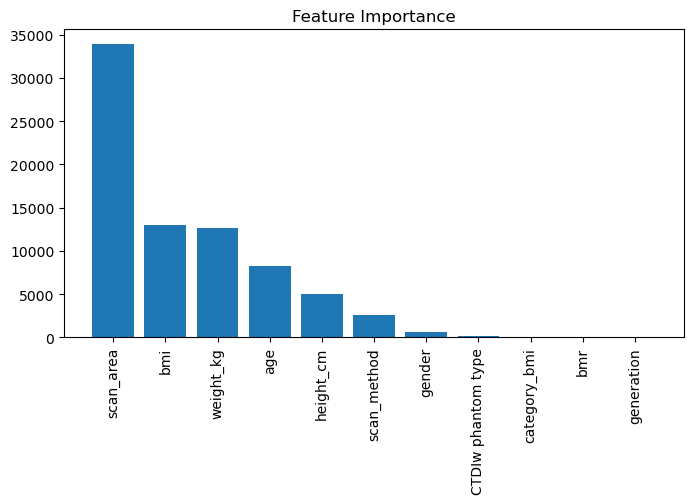

In [29]:
# 特徴量の重要度の可視化
importances = model.feature_importance(importance_type='gain')
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 4))
plt.title('Feature Importance')
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), X.columns[indices], rotation=90)
plt.show()

### Permutation Feature Importance

In [57]:
from sklearn.inspection import permutation_importance
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

objective = 'mse' # 'mse or mae'

params = {
    'objective': objective,
    'random_state': 0, 
    'verbose': -1
}

test_scores = []
models = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train)):
    X_tr = X_train.iloc[tr_idx]
    X_va = X_train.iloc[va_idx]
    y_tr = y_train.iloc[tr_idx]
    y_va = y_train.iloc[va_idx]
    
    model = LGBMRegressor(**params, n_estimators=1000)
    model.fit(X_tr, y_tr,
              eval_set=[(X_va, y_va)],
              callbacks=[lgb.early_stopping(100),
                         lgb.log_evaluation(50)],)
    
    models.append(model)
    y_va_pred = model.predict(X_va)
    score = mean_absolute_error(y_va, y_va_pred)
    print(f'fold {fold+1} MSE valid: {score:.2f}')
    print('')
    
    # スコア、モデル、予測値の格納
    test_scores.append(score)

# クロスバリデーションの平均スコア
cv_score = np.mean(test_scores)
print(f'CV score: {cv_score:.2f}')

# 最初のモデルに対する特徴量の重要性
perm_importance = permutation_importance(models[0], X_va, y_va, scoring='neg_mean_absolute_error')

print(perm_importance.importances_mean)


Training until validation scores don't improve for 100 rounds
[50]	valid_0's l2: 28.8713
[100]	valid_0's l2: 29.2246
Early stopping, best iteration is:
[47]	valid_0's l2: 28.7506
fold 1 MSE valid: 2.88

Training until validation scores don't improve for 100 rounds
[50]	valid_0's l2: 20.1532
[100]	valid_0's l2: 19.4148
[150]	valid_0's l2: 18.9975
[200]	valid_0's l2: 18.9204
[250]	valid_0's l2: 19.0217
Early stopping, best iteration is:
[188]	valid_0's l2: 18.8498
fold 2 MSE valid: 2.71

Training until validation scores don't improve for 100 rounds
[50]	valid_0's l2: 57.6631
[100]	valid_0's l2: 51.8863
[150]	valid_0's l2: 47.8347
[200]	valid_0's l2: 43.8833
[250]	valid_0's l2: 40.8653
[300]	valid_0's l2: 38.69
[350]	valid_0's l2: 37.3858
[400]	valid_0's l2: 36.2534
[450]	valid_0's l2: 35.2089
[500]	valid_0's l2: 34.6093
[550]	valid_0's l2: 34.2134
[600]	valid_0's l2: 33.8413
[650]	valid_0's l2: 33.7737
[700]	valid_0's l2: 33.3815
[750]	valid_0's l2: 33.3832
[800]	valid_0's l2: 33.3117
[8

In [59]:
best_model = models[np.argmin(test_scores)]
perm_importance = permutation_importance(best_model, X_va, y_va, scoring='neg_mean_absolute_error')

print(perm_importance.importances_mean)


[0.76473387 0.59657411 0.0571045  0.40063784 1.05832102 5.90236129
 0.83990605 0.         1.17025109 0.         0.        ]


<BarContainer object of 11 artists>

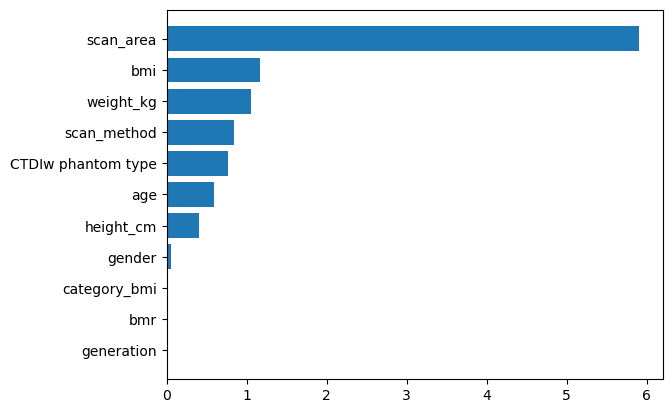

In [60]:
df_pfi = pd.DataFrame(
    data={'var_name': X_train.columns, "importance": perm_importance["importances_mean"]}
).sort_values('importance')

# PFIを可視化
plt.barh(
    df_pfi['var_name'],
    df_pfi['importance'],
)

### Feature Engineering

In [ ]:
# Combine 'scan_area', 'CTDIw phantom type', and 'category_bmi' into a new feature
data['combined_feature'] = data['scan_area'].astype(str) + "_" + data['CTDIw phantom type'].astype(str) + "_" + data['category_bmi'].astype(str)
